In [60]:
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG19

img_size = (224, 224)

def create_encoder(output_layer='block3_conv1'):
    vgg = VGG19(include_top=False, input_shape=(*img_size, 3))
    output = vgg.get_layer(output_layer).output
    
    model = Model(vgg.input, outputs=[output])
    model.build(img_size)
    return model

def transform(model, array):
    return model.predict(np.array([array]))[0]

In [61]:
from wct.img import imread
import numpy as np

encoder = create_encoder()
img = imread('images/nightlife.png')
img_map = transform(encoder, im)
img_map.shape

(56, 56, 256)

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, UpSampling2D
from wct.layers import ReflectingConv2D

def create_decoder(input_shape=(56, 56, 256)):
    return Sequential([
        Input(shape=input_shape),
        ReflectingConv2D(128, (3, 3), activation='relu', name='dec_block3_conv1'),
        UpSampling2D(interpolation='nearest', name='dec_block3_upsample'),
        ReflectingConv2D(128, (3, 3), activation='relu', name='dec_block3_conv2'),
        ReflectingConv2D(64, (3, 3), activation='relu', name='dec_block2_conv1'),
        UpSampling2D(interpolation='nearest', name='dec_block2_upsample'),
        ReflectingConv2D(64, (3, 3), activation='relu', name='dec_block1_conv1'),
        ReflectingConv2D(3, 3, activation=None, name='dec_output')
    ])

In [62]:
decoder = create_decoder()
reconstruction = transform(decoder, img_map)
reconstruction.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


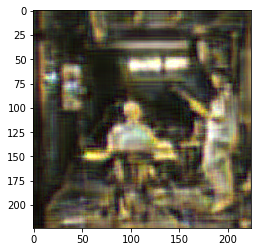

In [11]:
%matplotlib inline
from wct.img import imshow

decoder.load_weights('models/decoder0.h5')
reconstruction = decoder.predict(np.array([feature_map]))[0]
imshow(reconstruction)

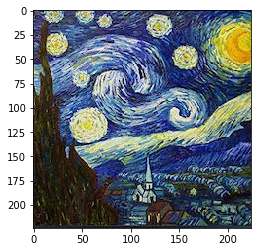

In [24]:
style = imread('styles/vangogh.jpg')
style_map = encoder.predict(np.array([style]))[0]
imshow(style)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


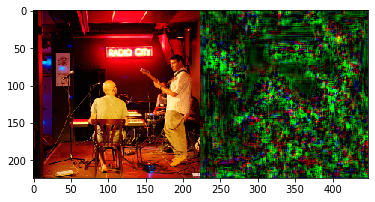

In [73]:
def whitening_transform(features):
    height, width, depth = features.shape
    features = np.transpose(features, (2, 0, 1)) # depth, height, width
    features = features.reshape(-1, width * height) # depth, width * height
    
    features -= features.mean(axis=1, keepdims=True) # center (mean wrt. spatial dimension)
    product = np.dot(features, features.T) / (width * height - 1) # why divide?
    Ec, wc, _ = np.linalg.svd(product)
    Dc = np.diag(wc)
    assert((product - Ec.dot(Dc).dot(Ec.T) < 1e-4).all()) # Ec * Dc * Ec^T == features * features^T
    Dc_minus_half = np.linalg.inv(Dc) ** 0.5
    return Ec.dot(Dc_minus_half).dot(Ec.T).dot(features)

#     kc = (wc > 1e-5).sum() # how many non-zero eigenvalues we have
#     print(kc)
#     features = features - features.mean()

img_map_uncor = whitening_transform(img_map)
img_map_uncor_viz = img_map_uncor.transpose().reshape(img_map.shape)
imshow(np.column_stack([img, transform(decoder, img_map_uncor_viz)]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


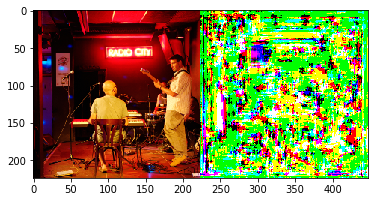

In [80]:
def coloring_transform(style_features, content_features):
    height, width, depth = style_features.shape
    style_features = np.transpose(style_features, (2, 0, 1)) # depth, height, width
    style_features = style_features.reshape(-1, width * height) # depth, width * height
    
    mean = style_features.mean(axis=1, keepdims=True) # center (mean wrt. spatial dimension)
    style_features -= mean
    
    product = np.dot(style_features, style_features.T) / (width * height - 1)
    Es, ws, _ = np.linalg.svd(product)
    Ds = np.diag(ws)
    return Es.dot(Ds).dot(Es.T).dot(content_features) + mean

new_image = coloring_transform(style_map, img_map_uncor)
new_image_viz = new_image.transpose().reshape(img_map.shape)
imshow(np.column_stack([img, transform(decoder, new_image_viz)]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


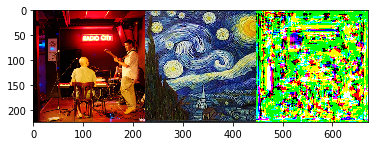

In [84]:
def blend(original, new, alpha=0.8):
    return alpha * new + (1 - alpha) * original

blended = blend(img_map, new_image_viz)
imshow(
    np.column_stack([
        img,
        style,
        transform(decoder, blended)
    ]
    )
)